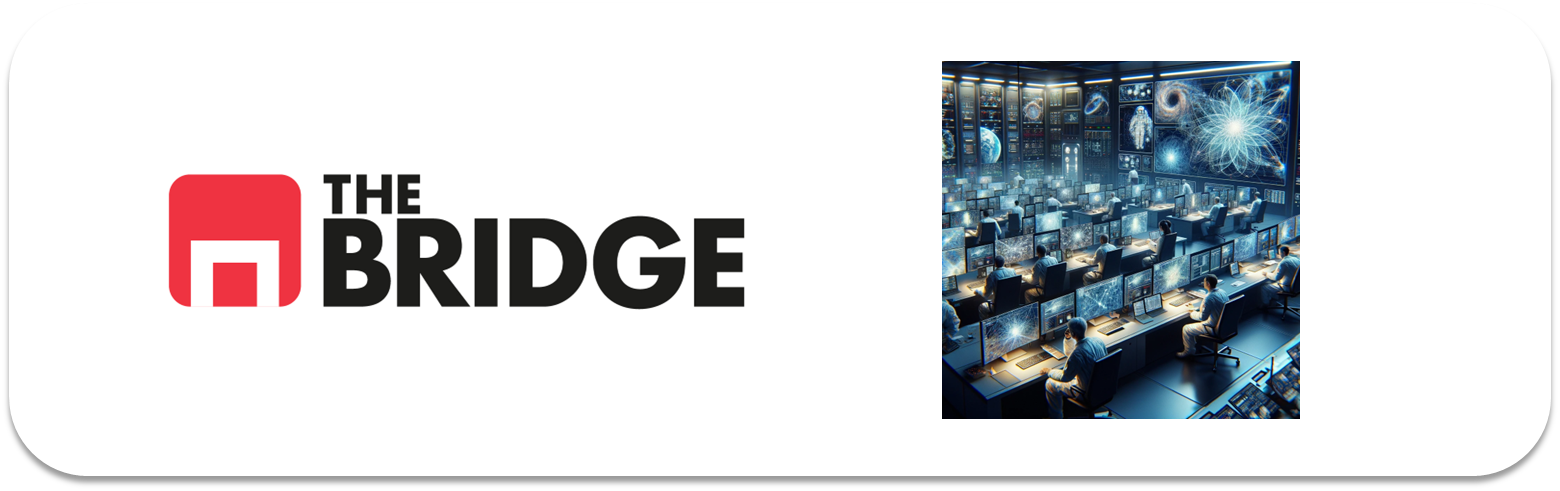

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import collections
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



In [2]:
# =============================================================================
# 1. Funciones para cargar imágenes y crear datasets
# =============================================================================
def load_images_from_directory(directory, target_size=(32, 32)):
    """
    Lee todas las imágenes en 'directory', redimensionándolas a target_size.
    Se extrae la etiqueta a partir del nombre del archivo: si contiene 'dog' se etiqueta como 0,
    si contiene 'cat' se etiqueta como 1.
    """
    X = []
    y = []
    file_names = []
    for file in os.listdir(directory):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(directory, file)
            try:
                image = Image.open(image_path).convert('RGB')
                image = image.resize(target_size)
                X.append(np.array(image))
                file_names.append(image_path)
                
                # Extraer etiqueta a partir del nombre del archivo
                if 'dog' in file.lower():
                    label = 0
                elif 'cat' in file.lower():
                    label = 1
                else:
                    raise ValueError(f"No se pudo determinar la etiqueta en {file}")
                y.append(label)
            except Exception as e:
                print(f"Error al procesar {file}: {e}")
    return np.array(X), np.array(y), file_names

In [3]:
# =============================================================================
# 1.1. Cargar el dataset de entrenamiento (4000 imágenes de 4 directorios)
# =============================================================================
train_dirs = ["data/github_train_0", "data/github_train_1", "data/github_train_2", "data/github_train_3"]
X_train_list = []
y_train_list = []
train_file_names = []
for d in train_dirs:
    print(f"Cargando imágenes de: {d}")
    X_tmp, y_tmp, files_tmp = load_images_from_directory(d)
    X_train_list.append(X_tmp)
    y_train_list.append(y_tmp)
    train_file_names.extend(files_tmp)

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)

Cargando imágenes de: data/github_train_0
Cargando imágenes de: data/github_train_1
Cargando imágenes de: data/github_train_2
Cargando imágenes de: data/github_train_3


Cargando imágenes de: data/github_test
Distribución de clases en train: Counter({1: 2000, 0: 2000})
Distribución de clases en test: Counter({1: 500, 0: 500})


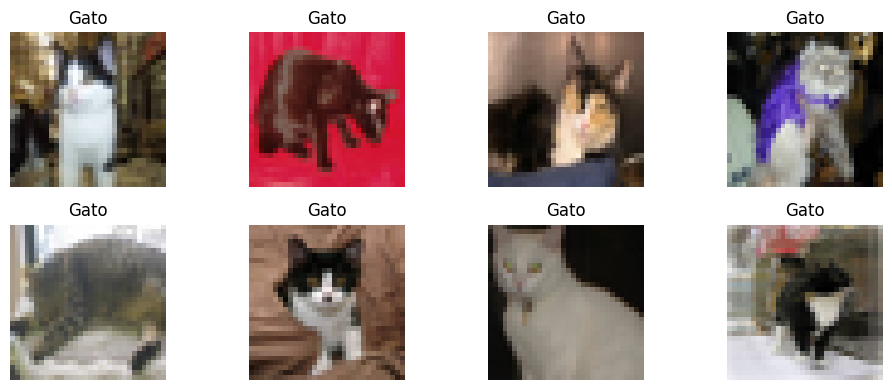

In [4]:
# =============================================================================
# 1.2. Cargar el dataset de test (1000 imágenes)
# =============================================================================
test_dir = "data/github_test"
print(f"Cargando imágenes de: {test_dir}")
X_test, y_test, test_file_names = load_images_from_directory(test_dir)

# Normalizamos las imágenes
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Mini EDA: Mostrar distribución de clases
print("Distribución de clases en train:", collections.Counter(y_train))
print("Distribución de clases en test:", collections.Counter(y_test))

# Visualización de algunas imágenes de entrenamiento
plt.figure(figsize=(10, 4))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_train[i])
    plt.title("Perro" if y_train[i] == 0 else "Gato")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# =============================================================================
# 2. Construcción del modelo DL (CNN con 2 bloques Conv+Pooling)
# =============================================================================
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    # Capa de salida: 2 neuronas (0: perro, 1: gato) con softmax
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

c:\Users\juanmoreno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,042 (652.51 KB)

 Trainable params: 167,042 (652.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7634 - loss: 0.4918 - val_accuracy: 0.6087 - val_loss: 0.7527
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7692 - loss: 0.4836 - val_accuracy: 0.6300 - val_loss: 0.7009
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7981 - loss: 0.4304 - val_accuracy: 0.7250 - val_loss: 0.5486
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8157 - loss: 0.3999 - val_accuracy: 0.6400 - val_loss: 0.7413
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8418 - loss: 0.3716 - val_accuracy: 0.6862 - val_loss: 0.6336
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8436 - loss: 0.3443 - val_accuracy: 0.6438 - val_loss: 0.7821
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8869 - loss: 0.2812 - val_accuracy: 0.7775 - val_loss: 0.5537
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8859 - loss: 0.2738 - val_accuracy:

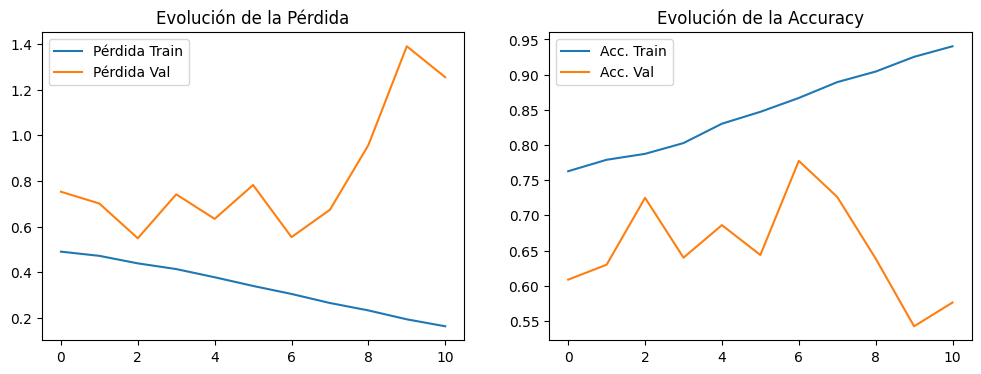

In [7]:
# =============================================================================
# 3. Entrenamiento del modelo con EarlyStopping y visualización del historial
# =============================================================================
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop])

# Visualización del historial de entrenamiento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida Train')
plt.plot(history.history['val_loss'], label='Pérdida Val')
plt.legend()
plt.title("Evolución de la Pérdida")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acc. Train')
plt.plot(history.history['val_accuracy'], label='Acc. Val')
plt.legend()
plt.title("Evolución de la Accuracy")

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7436 - loss: 0.5098

Test Loss: 0.5194 - Test Accuracy: 0.7490
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Reporte de Clasificación:
               precision    recall  f1-score   support

       Perro       0.75      0.75      0.75       500
        Gato       0.75      0.75      0.75       500

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.75      0.75      0.75      1000



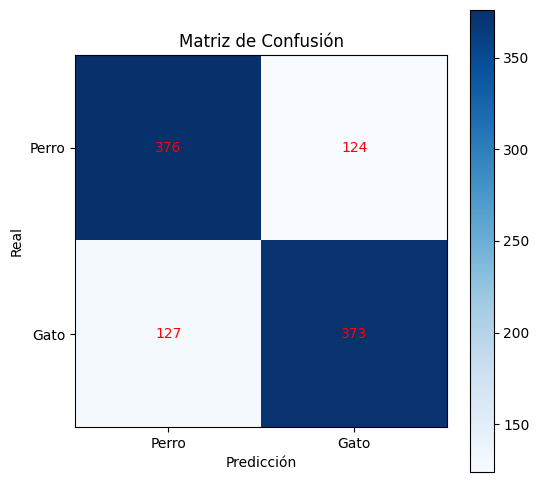

In [8]:
# =============================================================================
# 4. Evaluación del modelo: Reporte de clasificación y matriz de confusión
# =============================================================================
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.4f}")

# Predicciones en el conjunto de test
y_pred_prob = model.predict(X_test)  # Probabilidades para cada clase
y_pred = np.argmax(y_pred_prob, axis=1)

# Reporte de clasificación
report = classification_report(y_test, y_pred, target_names=["Perro", "Gato"])
print("\nReporte de Clasificación:\n", report)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap='Blues')
plt.title("Matriz de Confusión")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Perro", "Gato"])
plt.yticks(tick_marks, ["Perro", "Gato"])
# Mostrar valores en la matriz
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="red")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


Número total de imágenes mal clasificadas: 251
Error de clase 0 -> 1: seleccionadas 12 imágenes.
Error de clase 1 -> 0: seleccionadas 12 imágenes.


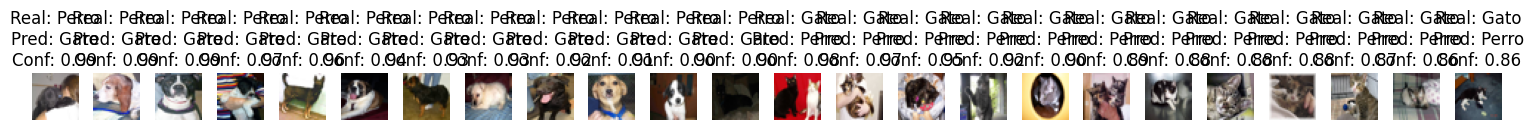

In [9]:
# =============================================================================
# 5. Selección de imágenes "difíciles": 10% de las mal clasificadas por cada error
# =============================================================================
misclassified_info = []
for i in range(len(y_test)):
    if y_test[i] != y_pred[i]:
        # Probabilidad asignada a la clase equivocada
        confidence = y_pred_prob[i][y_pred[i]]
        misclassified_info.append({
            'index': i,
            'true_label': y_test[i],
            'pred_label': y_pred[i],
            'confidence': confidence,
            'file_path': test_file_names[i]
        })

df_mis = pd.DataFrame(misclassified_info)
print("\nNúmero total de imágenes mal clasificadas:", len(df_mis))

selected_indices = []
# Procesamos cada error: perro clasificado como gato (0 -> 1) y gato clasificado como perro (1 -> 0)
for true_val, pred_val in [(0, 1), (1, 0)]:
    df_error = df_mis[(df_mis['true_label'] == true_val) & (df_mis['pred_label'] == pred_val)]
    count_select = max(1, int(0.1 * len(df_error)))  # Al menos 1 imagen
    df_error_sorted = df_error.sort_values(by='confidence', ascending=False)
    selected = df_error_sorted.head(count_select)
    selected_indices.extend(selected['index'].tolist())
    print(f"Error de clase {true_val} -> {pred_val}: seleccionadas {count_select} imágenes.")

# Visualizar las imágenes seleccionadas
plt.figure(figsize=(15, 5))
for i, idx in enumerate(selected_indices):
    plt.subplot(1, len(selected_indices), i+1)
    plt.imshow(X_test[idx])
    plt.title(f"Real: {'Perro' if y_test[idx]==0 else 'Gato'}\nPred: {'Perro' if y_pred[idx]==0 else 'Gato'}\nConf: {y_pred_prob[idx][y_pred[idx]]:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Entrenamiento con Image Augmentation...
Epoch 1/50
  4/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7259 - loss: 0.5157   

c:\Users\juanmoreno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6927 - loss: 0.5880 - val_accuracy: 0.7220 - val_loss: 0.5436
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7418 - loss: 0.5384 - val_accuracy: 0.7650 - val_loss: 0.5039
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7153 - loss: 0.5473 - val_accuracy: 0.7720 - val_loss: 0.4957
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7193 - loss: 0.5503 - val_accuracy: 0.7580 - val_loss: 0.5051
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7490 - loss: 0.5228 - val_accuracy: 0.7610 - val_loss: 0.5067
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7372 - loss: 0.5241 - val_accuracy: 0.7660 - val_loss: 0.4992
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7324 - loss: 0.5334 - val_accuracy: 0.7720 - val_loss: 0.4983
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7340 - loss: 0.5271 - val_accuracy: 0.775

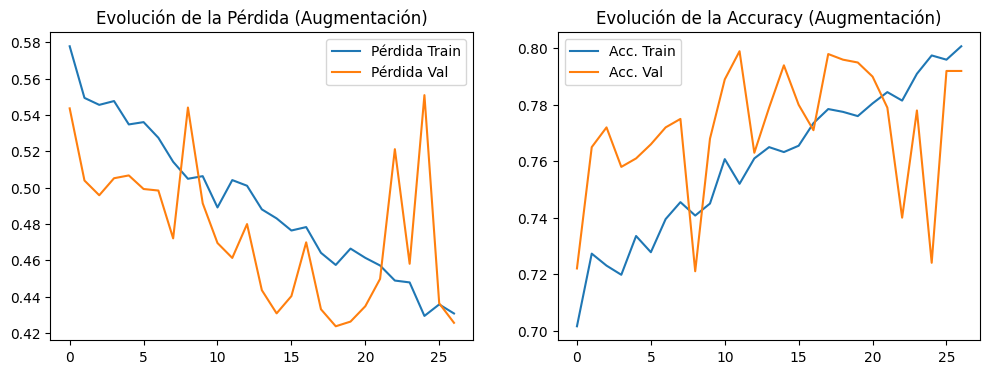

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7837 - loss: 0.3975

[Augmentación] Test Loss: 0.4236 - Test Accuracy: 0.7960
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

[Augmentación] Reporte de Clasificación:
               precision    recall  f1-score   support

       Perro       0.79      0.80      0.80       500
        Gato       0.80      0.79      0.79       500

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



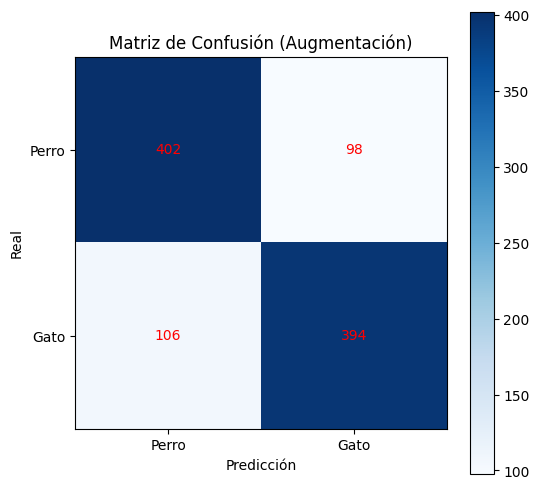


[Augmentación] Número total de imágenes mal clasificadas: 204
[Augmentación] Error de clase 0 -> 1: seleccionadas 9 imágenes.
[Augmentación] Error de clase 1 -> 0: seleccionadas 10 imágenes.


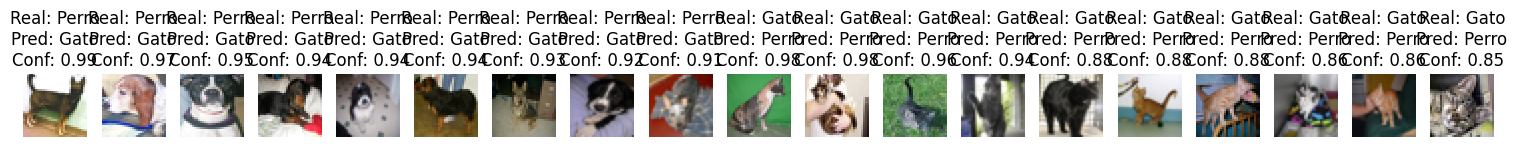

In [10]:
# =============================================================================
# Extra: Entrenamiento usando Image Augmentation (Generador de Imágenes)
# =============================================================================
# Se crea un generador con algunas transformaciones aleatorias
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Reiniciamos y entrenamos el modelo (o se puede definir un nuevo modelo)
print("\nEntrenamiento con Image Augmentation...")
history_aug = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                        epochs=50,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stop])

# Visualización del historial de entrenamiento con augmentación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_aug.history['loss'], label='Pérdida Train')
plt.plot(history_aug.history['val_loss'], label='Pérdida Val')
plt.legend()
plt.title("Evolución de la Pérdida (Augmentación)")

plt.subplot(1, 2, 2)
plt.plot(history_aug.history['accuracy'], label='Acc. Train')
plt.plot(history_aug.history['val_accuracy'], label='Acc. Val')
plt.legend()
plt.title("Evolución de la Accuracy (Augmentación)")
plt.show()

# Evaluación y selección de imágenes difíciles se repetirían de forma similar:
test_loss_aug, test_acc_aug = model.evaluate(X_test, y_test)
print(f"\n[Augmentación] Test Loss: {test_loss_aug:.4f} - Test Accuracy: {test_acc_aug:.4f}")

# Predicciones con el modelo entrenado con augmentation
y_pred_prob_aug = model.predict(X_test)
y_pred_aug = np.argmax(y_pred_prob_aug, axis=1)

report_aug = classification_report(y_test, y_pred_aug, target_names=["Perro", "Gato"])
print("\n[Augmentación] Reporte de Clasificación:\n", report_aug)

cm_aug = confusion_matrix(y_test, y_pred_aug)
plt.figure(figsize=(6, 6))
plt.imshow(cm_aug, cmap='Blues')
plt.title("Matriz de Confusión (Augmentación)")
plt.colorbar()
plt.xticks(tick_marks, ["Perro", "Gato"])
plt.yticks(tick_marks, ["Perro", "Gato"])
for i in range(cm_aug.shape[0]):
    for j in range(cm_aug.shape[1]):
        plt.text(j, i, cm_aug[i, j], ha="center", va="center", color="red")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Selección de imágenes mal clasificadas con augmentation
misclassified_info_aug = []
for i in range(len(y_test)):
    if y_test[i] != y_pred_aug[i]:
        confidence = y_pred_prob_aug[i][y_pred_aug[i]]
        misclassified_info_aug.append({
            'index': i,
            'true_label': y_test[i],
            'pred_label': y_pred_aug[i],
            'confidence': confidence,
            'file_path': test_file_names[i]
        })

df_mis_aug = pd.DataFrame(misclassified_info_aug)
print("\n[Augmentación] Número total de imágenes mal clasificadas:", len(df_mis_aug))

selected_indices_aug = []
for true_val, pred_val in [(0, 1), (1, 0)]:
    df_error = df_mis_aug[(df_mis_aug['true_label'] == true_val) & (df_mis_aug['pred_label'] == pred_val)]
    count_select = max(1, int(0.1 * len(df_error)))
    df_error_sorted = df_error.sort_values(by='confidence', ascending=False)
    selected = df_error_sorted.head(count_select)
    selected_indices_aug.extend(selected['index'].tolist())
    print(f"[Augmentación] Error de clase {true_val} -> {pred_val}: seleccionadas {count_select} imágenes.")

plt.figure(figsize=(15, 5))
for i, idx in enumerate(selected_indices_aug):
    plt.subplot(1, len(selected_indices_aug), i+1)
    plt.imshow(X_test[idx])
    plt.title(f"Real: {'Perro' if y_test[idx]==0 else 'Gato'}\nPred: {'Perro' if y_pred_aug[idx]==0 else 'Gato'}\nConf: {y_pred_prob_aug[idx][y_pred_aug[idx]]:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()